## Training Neural Networks in Pytorch

Here I'm going to train a Neural Network using backpropagation

### Let's start by calculating the losses 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3289, grad_fn=<NllLossBackward>)


In [3]:
# Build a feed-forward network with a different kind of loss
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# With a log-softmax output, you want to use the negative log likelihood loss, nn.NLLLoss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(-0.0211, grad_fn=<NllLossBackward>)


### Autograd for backpropagation

Torch provides a module, autograd, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss.

In [4]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.7799,  0.9862],
        [-1.6316, -1.0634]], requires_grad=True)


In [9]:
# we can see the operation that created y
y = x**2
print(y)
## grad_fn shows the function that generated this variable
print(y.grad_fn)

# same with z
z = y.mean()
print(z)

tensor([[0.6082, 0.9727],
        [2.6621, 1.1308]], grad_fn=<PowBackward0>)
tensor(1.3434, grad_fn=<MeanBackward0>)


### Loss and Autograd together

In [10]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [11]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0024,  0.0024,  0.0024,  ...,  0.0024,  0.0024,  0.0024],
        [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
        [-0.0045, -0.0045, -0.0045,  ..., -0.0045, -0.0045, -0.0045],
        ...,
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


### Optimizer

Last thing needed to train the network is an optimizer that we'll use to update the weights with the gradients

We get these from PyTorch's optim package

In [12]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training the network

Putting all these pieces together we can start training our network

Here we're going to loop through trainloader to get our training batches.

Note that I have a line of code optimizer.zero_grad(). When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [13]:

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # Forward pass, then backward pass, then update weights
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8464087042600108
Training loss: 0.8124597188887566
Training loss: 0.5230150037546402
Training loss: 0.4272247979254611
Training loss: 0.3804115919447911


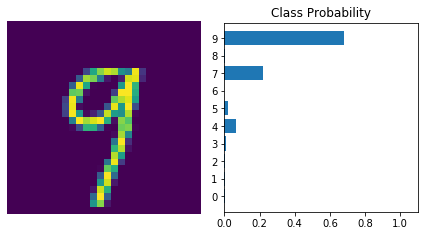

In [14]:
# Checking out the predictions with our network trained

%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)